In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [ ]:
num_epochs = 5
batch_size = 40
learning_rate = 0.001
classes = ('plane', 'car' , 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
n_total_step = len(train_loader)
print(n_total_step, len(test_loader))

1250 250


### VGG16 Model Training

In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.3MB/s]


In [ ]:
for epoch in range(num_epochs):
  for i, (imgs , labels) in enumerate(train_loader):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    labels_hat = model(imgs)
    n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
    loss_value = criterion(labels_hat, labels)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 250 == 0:
      print(f'epoch {epoch+1}/{num_epochs}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
  print()

epoch 1/5, step: 250/1250: loss = 0.52163, acc = 75.00%
epoch 1/5, step: 500/1250: loss = 0.28709, acc = 90.00%
epoch 1/5, step: 750/1250: loss = 0.16889, acc = 97.50%
epoch 1/5, step: 1000/1250: loss = 0.38465, acc = 87.50%
epoch 1/5, step: 1250/1250: loss = 0.33414, acc = 85.00%

epoch 2/5, step: 250/1250: loss = 0.43268, acc = 85.00%
epoch 2/5, step: 500/1250: loss = 0.14142, acc = 95.00%
epoch 2/5, step: 750/1250: loss = 0.34591, acc = 85.00%
epoch 2/5, step: 1000/1250: loss = 0.17772, acc = 87.50%
epoch 2/5, step: 1250/1250: loss = 0.15219, acc = 90.00%

epoch 3/5, step: 250/1250: loss = 0.09198, acc = 97.50%
epoch 3/5, step: 500/1250: loss = 0.07575, acc = 100.00%
epoch 3/5, step: 750/1250: loss = 0.08953, acc = 95.00%
epoch 3/5, step: 1000/1250: loss = 0.26179, acc = 92.50%
epoch 3/5, step: 1250/1250: loss = 0.23501, acc = 90.00%

epoch 4/5, step: 250/1250: loss = 0.08031, acc = 97.50%
epoch 4/5, step: 500/1250: loss = 0.06315, acc = 95.00%
epoch 4/5, step: 750/1250: loss = 0.30

In [ ]:
torch.save(model.state_dict(), 'cifar10_vgg16.pth')
print("Model saved!")

Model saved!


### Machine Unlearning

In [ ]:
learned_model = models.vgg16()
input_lastLayer = learned_model.classifier[6].in_features
learned_model.classifier[6] = nn.Linear(input_lastLayer,10)
learned_model.load_state_dict(torch.load('cifar10_vgg16.pth', map_location=DEVICE))
learned_model.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Overall accuracy 92.36%


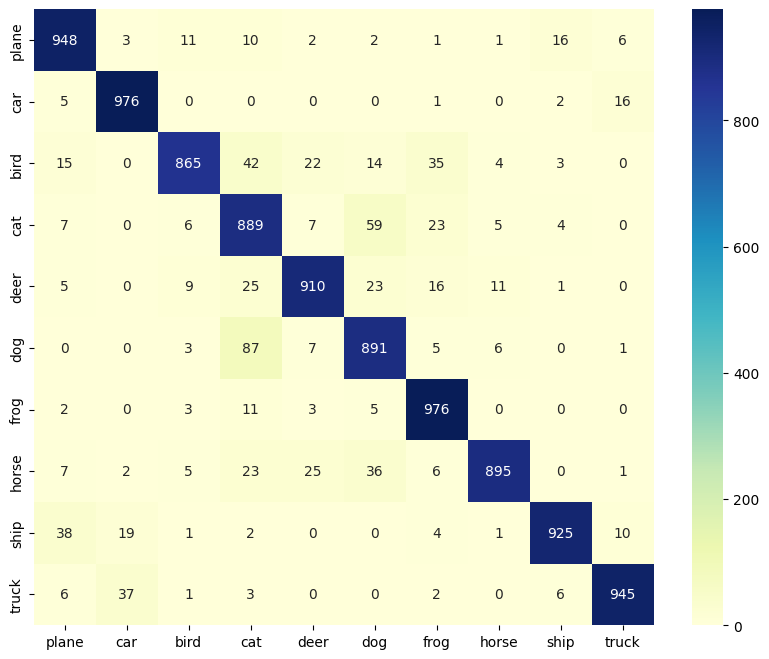

92.36

In [ ]:
def evaluate_model(model, test_loader, mask=None):
  n_corrects = 0
  n_samples = 0
  for i, (test_images_set , test_labels_set) in enumerate(test_loader):
    test_images_set = test_images_set.to(DEVICE)
    test_labels_set = test_labels_set.to(DEVICE)
    if mask is not None:
      y_predicted = model(test_images_set, mask)
    else:
      y_predicted = model(test_images_set)
    labels_predicted = y_predicted.argmax(axis = 1)
    n_corrects += (labels_predicted==test_labels_set).sum().item()
    n_samples += test_labels_set.size(0)
  acc = (n_corrects / n_samples) * 100
  print(f'Overall accuracy {acc}%')
  heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      if mask is not None:
        outputs = model(images, mask)
      else:
        outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(batch_size):
        true_label = labels[i].item()
        predicted_label = predicted[i].item()
        heatmap.iloc[true_label,predicted_label] += 1
  _, ax = plt.subplots(figsize=(10, 8))
  ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
  plt.show()

  return acc

evaluate_model(learned_model, test_loader)

In [ ]:
class2idx = {k: v for v, k in enumerate(classes)}
target_class = class2idx['plane'] # 'plane', 'car' , 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
target_indices = [i for i, label in enumerate(train_dataset.targets) if label == target_class]
non_target_indices = [i for i, label in enumerate(train_dataset.targets) if label != target_class]
target_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, target_indices), batch_size=1, shuffle=True)
non_target_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, non_target_indices), batch_size=1, shuffle=True)

In [ ]:
class Custom_VGG16(nn.Module):
  def __init__(self, vgg16_model):
    super(Custom_VGG16, self).__init__()
    self.features = vgg16_model.features
    self.classifier = vgg16_model.classifier

  def forward(self, x, mask=None):
    x = self.features(x)
    if mask is not None:
      x = x * mask
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

unl_model = Custom_VGG16(learned_model)

In [ ]:
def identify_neurons_to_mask(model, data_loader, layer_name, threshold=0.5):
    layer_activations = []

    def hook_fn(module, input, output):
        layer_activations.append(output.detach().cpu())

    handle = getattr(model, layer_name).register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(data_loader):
            images = images.to(DEVICE)
            model(images)
    handle.remove()

    activations = torch.cat(layer_activations, dim=0)
    avg_activation = torch.mean(activations, dim=0)

    mask = avg_activation < threshold
    return mask

unl_mask = identify_neurons_to_mask(unl_model, target_loader, 'features')

100%|██████████| 5000/5000 [22:17<00:00,  3.74it/s]


In [ ]:
unl_mask

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [

In [ ]:
with open('unl_mask.pkl', 'wb') as file:
    pickle.dump(unl_mask, file)

Overall accuracy 82.41000000000001%


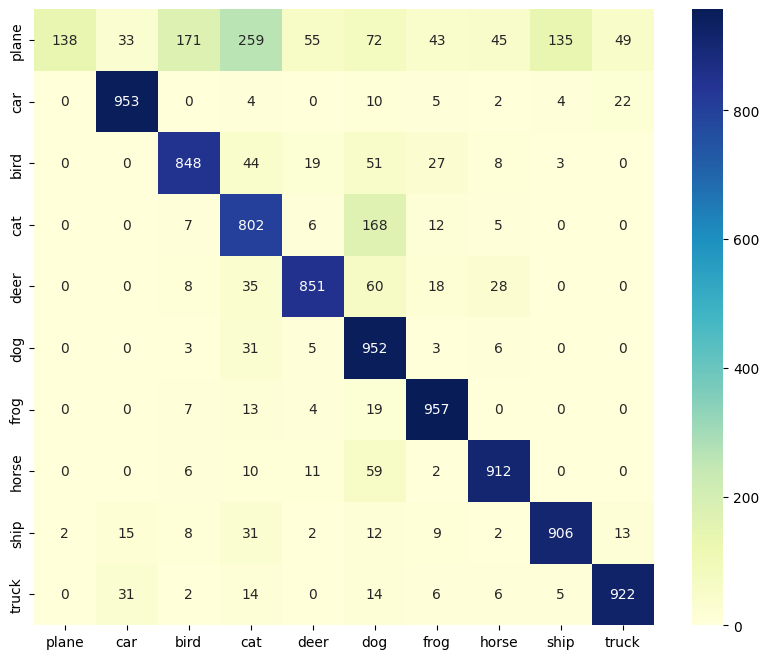

82.41000000000001

In [ ]:
evaluate_model(unl_model, test_loader, mask=unl_mask.to(DEVICE))

### Classification Reports

In [ ]:
with open('unl_mask.pkl', 'rb') as file:
    unl_mask = pickle.load(file)

unl_mask

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [

In [ ]:
def get_classification_report(model, data_loader, mask=None):
  y_true = []
  y_pred = []
  with torch.no_grad():
    for (test_images_set , test_labels_set) in tqdm(data_loader):
      test_images_set = test_images_set.to(DEVICE)
      test_labels_set = test_labels_set.to(DEVICE)
      if mask is not None:
        y_predicted = model(test_images_set, mask)
      else:
        y_predicted = model(test_images_set)
      labels_predicted = y_predicted.argmax(axis = 1)
      y_true.extend(test_labels_set.cpu().numpy())
      y_pred.extend(labels_predicted.cpu().numpy())
  return classification_report(y_true, y_pred)

In [ ]:
class2idx = {k: v for v, k in enumerate(classes)}
target_class = class2idx['plane'] # 'plane', 'car' , 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
sub_test_indices = [i for i, labels in enumerate(test_dataset.targets)]
sub_non_target_test_indices = [i for i, label in enumerate(test_dataset.targets) if label != target_class]
sub_test_indices = sub_test_indices[:500]
sub_non_target_test_indices = sub_non_target_test_indices[:500]
sub_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, sub_test_indices), batch_size=1, shuffle=True)
sub_non_target_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, sub_non_target_test_indices), batch_size=1, shuffle=True)

In [ ]:
print(get_classification_report(learned_model, sub_test_loader, mask=None))
print('\n----------------------------------------------------------------------\n')
print(get_classification_report(unl_model, sub_test_loader, mask=unl_mask.to(DEVICE)))
print('\n----------------------------------------------------------------------\n')
print(get_classification_report(learned_model, sub_non_target_test_loader, mask=None))
print('\n----------------------------------------------------------------------\n')
print(get_classification_report(unl_model, sub_non_target_test_loader, mask=unl_mask.to(DEVICE)))

100%|██████████| 500/500 [01:27<00:00,  5.68it/s]


              precision    recall  f1-score   support

           0       0.92      0.81      0.86        57
           1       0.95      0.98      0.96        41
           2       0.98      0.80      0.88        51
           3       0.75      0.90      0.81        49
           4       0.95      0.95      0.95        40
           5       0.82      0.94      0.87        48
           6       0.91      0.98      0.95        54
           7       1.00      0.85      0.92        47
           8       0.96      0.96      0.96        57
           9       0.93      0.95      0.94        56

    accuracy                           0.91       500
   macro avg       0.92      0.91      0.91       500
weighted avg       0.92      0.91      0.91       500


----------------------------------------------------------------------



100%|██████████| 500/500 [01:30<00:00,  5.51it/s]


              precision    recall  f1-score   support

           0       1.00      0.09      0.16        57
           1       0.91      0.98      0.94        41
           2       0.82      0.82      0.82        51
           3       0.54      0.76      0.63        49
           4       0.83      0.75      0.79        40
           5       0.59      0.98      0.74        48
           6       0.88      0.93      0.90        54
           7       0.91      0.83      0.87        47
           8       0.84      0.89      0.86        57
           9       0.91      0.91      0.91        56

    accuracy                           0.78       500
   macro avg       0.82      0.79      0.76       500
weighted avg       0.83      0.78      0.76       500


----------------------------------------------------------------------



100%|██████████| 500/500 [01:32<00:00,  5.42it/s]
c:\Users\anule\anaconda3\envs\mach_unl_project\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anule\anaconda3\envs\mach_unl_project\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anule\anaconda3\envs\mach_unl_project\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.96      0.98      0.97        44
           2       1.00      0.80      0.89        55
           3       0.75      0.86      0.80        51
           4       0.94      0.94      0.94        47
           5       0.90      0.92      0.91        60
           6       0.91      0.98      0.95        65
           7       0.98      0.89      0.93        53
           8       0.98      0.97      0.97        60
           9       0.98      0.95      0.97        65

    accuracy                           0.92       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.93      0.92      0.93       500


----------------------------------------------------------------------



100%|██████████| 500/500 [01:30<00:00,  5.50it/s]

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        44
           2       0.95      0.76      0.85        55
           3       0.68      0.80      0.74        51
           4       0.95      0.81      0.87        47
           5       0.66      0.95      0.78        60
           6       0.87      0.91      0.89        65
           7       0.98      0.87      0.92        53
           8       0.98      0.82      0.89        60
           9       0.97      0.91      0.94        65

    accuracy                           0.87       500
   macro avg       0.89      0.86      0.87       500
weighted avg       0.89      0.87      0.87       500

